In [49]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN, MNIST, EMNIST, SEMEION, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [50]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

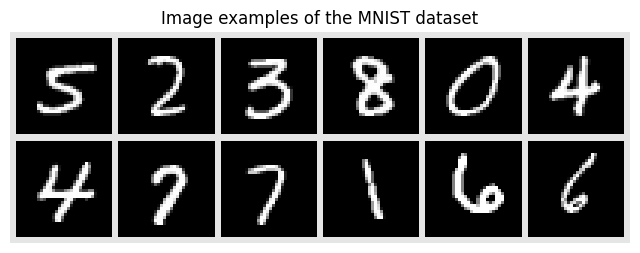

In [51]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [52]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


In [53]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [54]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [55]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


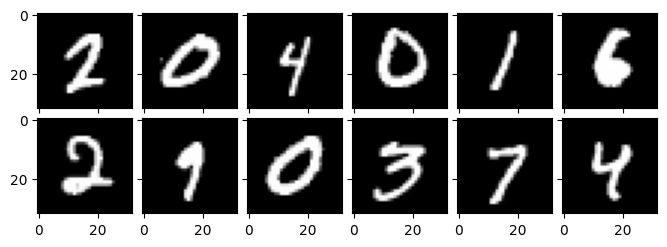

In [56]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [57]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


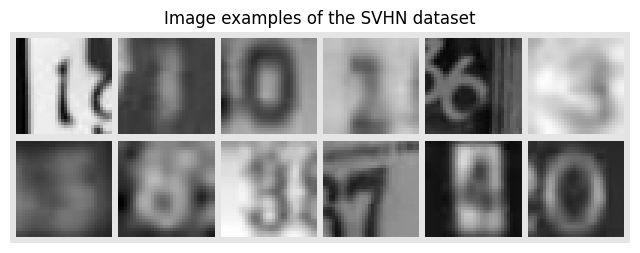

In [58]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [59]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [60]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [61]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

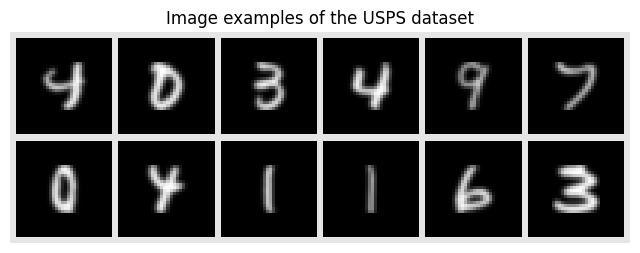

In [62]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [63]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [64]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


In [65]:
!pip install umap-learn
from umap import UMAP

Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [66]:
# MNIST
MNIST_Xtrain = MNIST_Xtrain_ima.reshape((MNIST_Xtrain_ima.shape[0], -1))
MNIST_Xtest = MNIST_Xtest_ima.reshape((MNIST_Xtest_ima.shape[0], -1))

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain = USPS_Xtrain_ima.reshape((USPS_Xtrain_ima.shape[0], -1))
USPS_Xtest = USPS_Xtest_ima.reshape((USPS_Xtest_ima.shape[0], -1))

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain = SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0], -1)
SVHN_Xtest = SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0], -1)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [67]:
np.random.seed(7)

# Reduced MNIST
rand_inds_mnist = np.random.choice(MNIST_Xtrain.shape[0], 1000, replace = False)
MNIST_Xtrain_res = MNIST_Xtrain[rand_inds_mnist]
MNIST_ytrain_res = MNIST_ytrain[rand_inds_mnist]


# Reduced USPS
rand_inds_usps = np.random.choice(USPS_Xtrain.shape[0], 1000, replace = False)
USPS_Xtrain_res = USPS_Xtrain[rand_inds_usps]
USPS_ytrain_res = USPS_ytrain[rand_inds_usps]

# Reduced SVHN
rand_inds_svhn = np.random.choice(SVHN_Xtrain.shape[0], 1000, replace = False)
SVHN_Xtrain_res = SVHN_Xtrain[rand_inds_svhn]
SVHN_ytrain_res = SVHN_ytrain[rand_inds_svhn]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [68]:
xtot.shape, nMNIST, nUSPS, nSVHN

((3000, 1024), 1000, 1000, 1000)

In [69]:
%time xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

CPU times: user 21.4 s, sys: 378 ms, total: 21.8 s
Wall time: 29.7 s
(3000, 2)


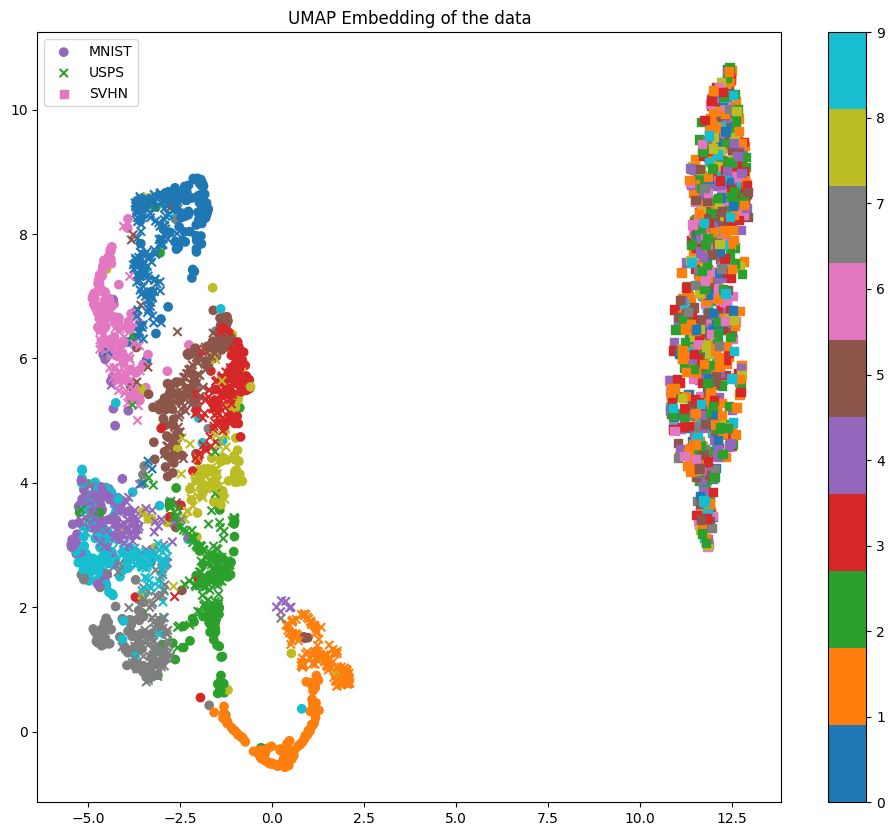

In [70]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data');

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

USPS and MNIST share similarities as they both consist of handwritten numerical digits, whereas SVHN presents notable differences as it comprises images of numerical digits depicted in printed font styles.

CPU times: user 21.1 s, sys: 157 ms, total: 21.3 s
Wall time: 28.6 s
(3000, 2)


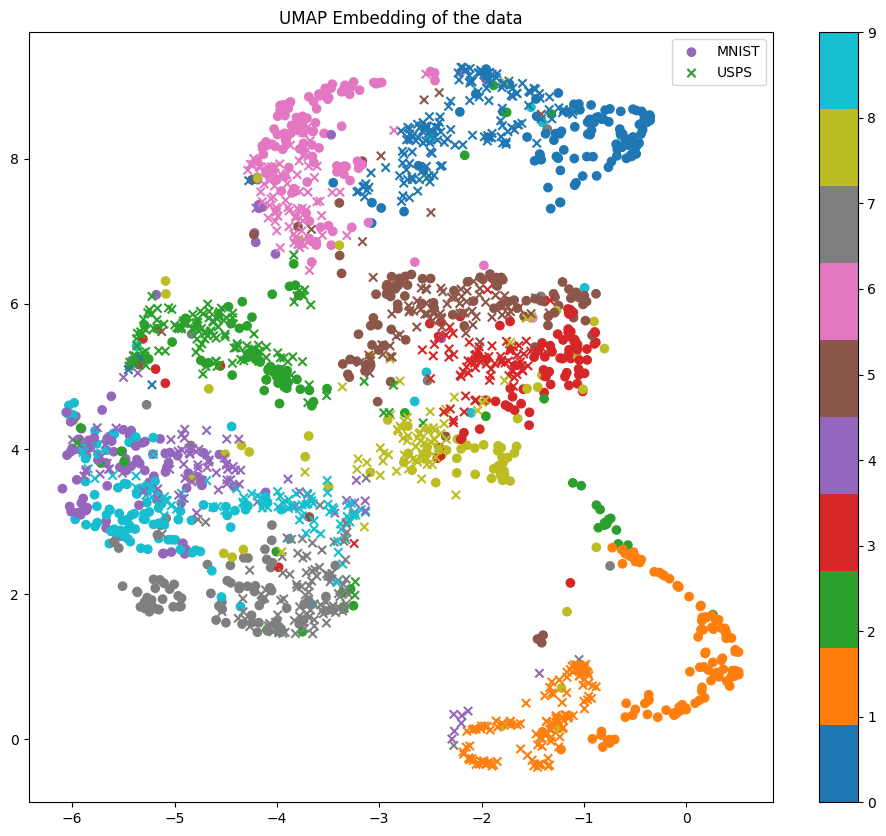

In [71]:
%time xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
# plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data');

**Question**: Can you see a domain shift between the datasets ?

Yes, the domain shift can be observed. Additionally, in MNIST, digits that are visually similar, such as 0, 1, 3, 4, 7, and 9, tend to cluster closely together on plots due to their shared characteristics in terms of strokes and shapes. On the other hand, digits with distinct visual features, such as 2, 5, 6, and 8, might exhibit more pronounced variations in positioning across the plot due to their dissimilar shapes and patterns.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [72]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 30.7 s, sys: 198 ms, total: 30.9 s
Wall time: 34.1 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


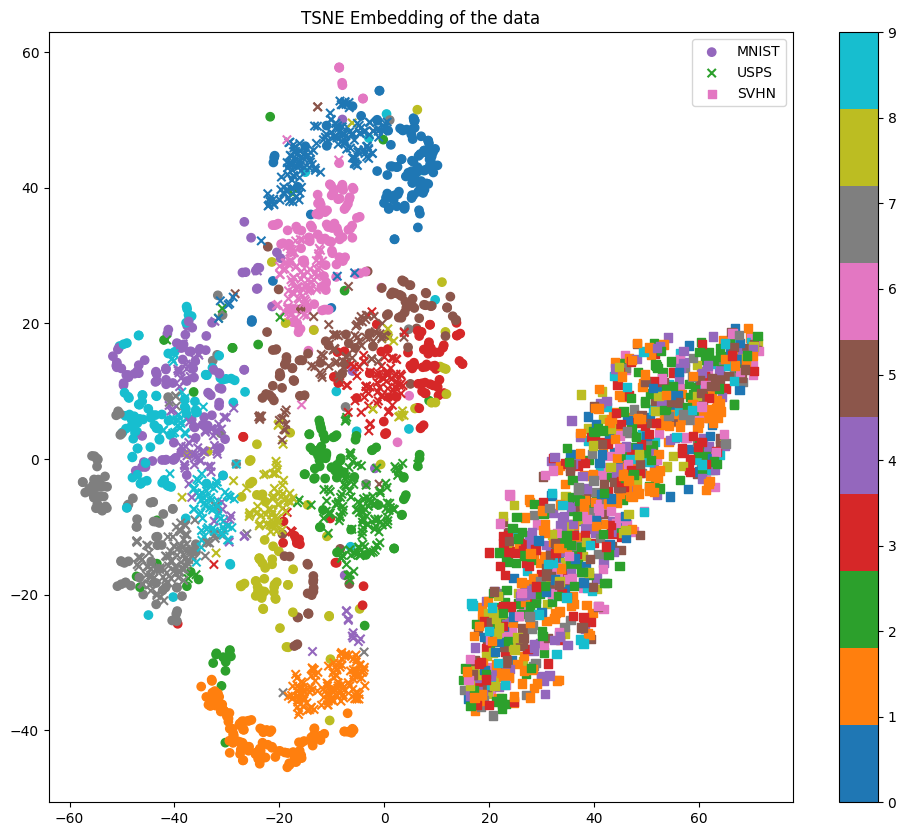

In [73]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data');

**Question**: can you confirm your previous conclusions ?

Yes, previous conclusions can be confirmed.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

CPU times: user 5.38 s, sys: 146 ms, total: 5.53 s
Wall time: 5.24 s
(1000, 2)


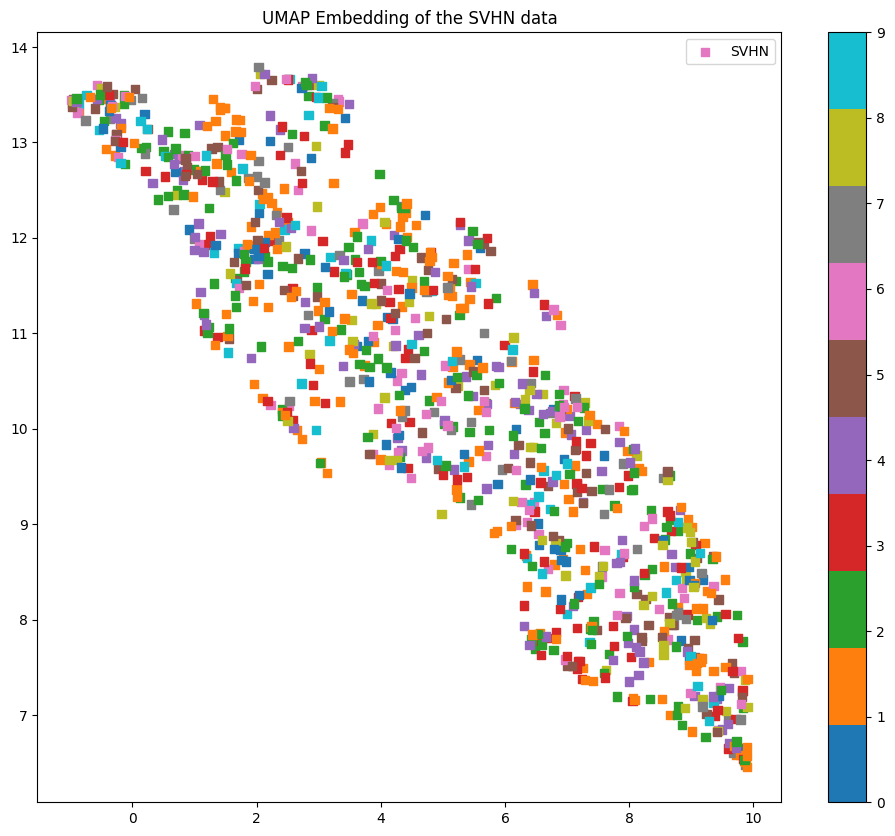

In [74]:
%time xpSVHN = UMAP().fit_transform(SVHN_Xtrain_res) # this should take ~50sec

print(xpSVHN.shape)

plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the SVHN data');

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

In the case of the SVHN dataset, the data may not be as clearly clustered or well-separated as for the MNIST and USPS datasets due to several factors, including the nature of the input space of dimensionality reduction techniques like UMAP. SVHN images typically have higher dimensionality compared to MNIST and USPS because they capture more complex visual features (being real world images), such as color, texture, and background context. When using dimensionality reduction techniques like UMAP, which aim to preserve local and global structure in the data, the higher dimensionality of SVHN images can lead to a more intricate and interconnected manifold in the reduced space. As a result, distinguishing clear clusters and boundaries between different digits becomes more challenging, especially when compared to the simpler and more homogeneous representations of handwritten digits in MNIST and USPS. Additionally, SVHN images may exhibit greater variability and diversity in terms of digit appearance, handwriting styles, and font variations, further complicating the clustering process and contributing to the observed difficulty in achieving well-defined clusters. Therefore, the complex and high-dimensional nature of SVHN images, combined with the inherent variability and diversity within the dataset, can make it more challenging to achieve clear clustering compared to MNIST and USPS.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

### 1. Source: MNIST, Target: USPS

In [75]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [91]:
from sklearn.decomposition import PCA
import numpy as np

def SA(XTrainS, XTestS, XTrainT, XTestT, d=10):
    """
    Subspace Alignment (SA)

    Input
    XTrainS : Input training source data [NTrS,D]
    XTestS : Input test source data [NTeS,D]
    XTrainT : Input training target data [NTrT,D]
    XTestT : Input test target data [NTeT,D]
    d : number of PCA components

    Output
    XTrainSp : projected and transformed source training data [NTrS,d]
    XTestSp : projected and transformed source test data [NTeS,d]
    XTrainTp : projected training target data [NTrT,d]
    XTestTp : projected test target data [NTeT,d]
    """
    pcaS = PCA(d).fit(XTrainS)
    pcaT = PCA(d).fit(XTrainT)
    US = np.transpose(pcaS.components_)[:, :d]
    UT = np.transpose(pcaT.components_)[:, :d]
    M = np.transpose(US).dot(UT)
    XTrainSp = XTrainS.dot(US.dot(M))
    XTrainTp = XTrainT.dot(UT)

    XTestSp = XTestS.dot(US.dot(M))
    XTestTp = XTestT.dot(UT)

    return XTrainSp, XTestSp, XTrainTp, XTestTp

In [89]:
from sklearn.decomposition import PCA
import numpy as np

def SA(XTrainS, XTestS, XTrainT, XTestT, d=10):
    """
    Subspace Alignment (SA)

    Input
    XTrainS : Input training source data [NTrS,D]
    XTestS : Input test source data [NTeS,D]
    XTrainT : Input training target data [NTrT,D]
    XTestT : Input test target data [NTeT,D]
    d : number of PCA components

    Output
    XTrainSp : projected and transformed source training data [NTrS,d]
    XTestSp : projected and transformed source test data [NTeS,d]
    XTrainTp : projected training target data [NTrT,d]
    XTestTp : projected test target data [NTeT,d]
    """
    # Step 1: Perform PCA on the source domain
    pca_source = PCA(n_components = d)
    pca_source.fit(XTrainS)
    source_components = pca_source.components_

    # Step 2: Perform PCA on the target domain
    pca_target = PCA(n_components = d)
    pca_target.fit(XTrainT)
    target_components = pca_target.components_

    # Step 3: Compute the transformation matrix using the PCA components
    transformation_matrix = np.dot(source_components.T, target_components.T)

    # Step 4: Transform both the source and target domain data using the transformation matrix
    XTrainSp = np.dot(XTrainS, transformation_matrix)
    XTestSp = np.dot(XTestS, transformation_matrix)
    XTrainTp = np.dot(XTrainT, transformation_matrix)
    XTestTp = np.dot(XTestT, transformation_matrix)

    return XTrainSp, XTestSp, XTrainTp, XTestTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import time

start_time = time.time()
LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
LR_model.fit(XtrainS, ytrainS)
y_preds = LR_model.predict(XtestT)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f}s")
print("\nClassification Report:")
print(classification_report(ytestT, y_preds))
print("Accuracy:", accuracy_score(ytestT, y_preds))

Time taken: 3.57s

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.30      0.45       359
           1       0.76      0.95      0.85       264
           2       0.86      0.48      0.61       198
           3       0.88      0.34      0.49       166
           4       0.68      0.70      0.69       200
           5       0.36      0.32      0.34       160
           6       0.34      0.96      0.50       170
           7       0.51      0.90      0.65       147
           8       0.86      0.11      0.19       166
           9       0.41      0.64      0.50       177

    accuracy                           0.56      2007
   macro avg       0.66      0.57      0.53      2007
weighted avg       0.70      0.56      0.54      2007

Accuracy: 0.5610363726955655


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

In [78]:
def dim_red_pca(XtrainS, XtestS, XtrainT, XtestT, d = 10):

  pca = PCA(n_components = d)
  pca.fit(XtrainS)

  XtrainS_pca = pca.transform(XtrainS)
  XtestS_pca = pca.transform(XtestS)
  XtrainT_pca = pca.transform(XtrainT)
  XtestT_pca = pca.transform(XtestT)

  return XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca

In [79]:
XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = dim_red_pca(XtrainS, XtestS, XtrainT, XtestT, d = 10)

In [80]:
start_time = time.time()
LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
LR_model.fit(XtrainS_pca, ytrainS)
y_preds = LR_model.predict(XtestT_pca)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f}s")
print("\nClassification Report:")
print(classification_report(ytestT, y_preds))
print("Accuracy:", accuracy_score(ytestT, y_preds))

Time taken: 0.08s

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.29      0.45       359
           1       0.66      0.96      0.78       264
           2       0.65      0.42      0.51       198
           3       0.90      0.42      0.57       166
           4       0.43      0.61      0.50       200
           5       0.51      0.35      0.42       160
           6       0.36      0.94      0.52       170
           7       0.65      0.80      0.72       147
           8       0.84      0.31      0.45       166
           9       0.42      0.53      0.47       177

    accuracy                           0.55      2007
   macro avg       0.64      0.56      0.54      2007
weighted avg       0.66      0.55      0.54      2007

Accuracy: 0.5540607872446437


In [48]:
# Experimenting with different values of d
d_values = [10, 30, 50, 70, 100, 200, 300]

accuracy_scores = {}
time_taken = {}

for d in tqdm(d_values):
    XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = dim_red_pca(XtrainS, XtestS, XtrainT, XtestT, d = d)

    start_time = time.time()
    LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
    LR_model.fit(XtrainS_pca, ytrainS)
    y_preds = LR_model.predict(XtestT_pca)
    end_time = time.time()

    accuracy = accuracy_score(ytestT, y_preds)
    accuracy_scores[d] = accuracy
    time_taken[d] = end_time - start_time

print("Accuracy Scores for Different Values of d:")
for d, accuracy in accuracy_scores.items():
    print(f"d={d}: Accuracy={accuracy}, time taken = {time_taken[d]:.2f} s")

  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy Scores for Different Values of d:
d=10: Accuracy=0.5540607872446437, time taken = 0.14 s
d=30: Accuracy=0.5430991529646239, time taken = 0.21 s
d=50: Accuracy=0.5490782262082711, time taken = 0.25 s
d=70: Accuracy=0.5615346287992028, time taken = 0.28 s
d=100: Accuracy=0.5595416043846537, time taken = 0.31 s
d=200: Accuracy=0.5540607872446437, time taken = 0.42 s
d=300: Accuracy=0.5585450921773791, time taken = 0.52 s


This approach allows us to observe whether dimensionality reduction using PCA affects the performance of the logistic regression model on the target domain test set compared to the full-dimensional data approach. The difference with the previous full-training apporoach is that we are reducing the number of features based on which the models are being trained, making it simpler (and quicker) for them.

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

In [92]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def evaluate_model(XTrainSp, XTestSp, XTrainTp, XTestTp, yTrainS, yTestT):
    # Linear model: Logistic Regression
    LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
    LR_model.fit(XTrainSp, yTrainS)
    LR_accuracy = accuracy_score(yTestT, LR_model.predict(XTestTp))

    # Non-linear model: Support Vector Classifier
    SVC_model = SVC(kernel = 'rbf', random_state = 7)
    SVC_model.fit(XTrainSp, yTrainS)
    SVC_accuracy = accuracy_score(yTestT, SVC_model.predict(XTestTp))

    # Deep Learning model: MLP
    MLP_model = MLPClassifier(hidden_layer_sizes = (16,32), random_state = 7, max_iter = 1000)
    MLP_model.fit(XTrainSp, yTrainS)
    MLP_accuracy = accuracy_score(yTestT, MLP_model.predict(XTestTp))

    return LR_accuracy, SVC_accuracy, MLP_accuracy


d_values = [10, 30, 70, 100, 200, 300]
results = {}

for d in tqdm(d_values):
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)
    LR_accuracy, SVC_accuracy, MLP_accuracy = evaluate_model(XTrainSp, XTestSp, XTrainTp, XTestTp, ytrainS, ytestT)
    results[d] = {'LR_accuracy': LR_accuracy, 'SVC_accuracy': SVC_accuracy, 'MLP_accuracy': MLP_accuracy}

print("Accuracies with different values of d:")
for d, acc in results.items():
    print(f"d={d}: LR Accuracy={acc['LR_accuracy']:.3f}, SVC Accuracy={acc['SVC_accuracy']:.3f}, MLP Accuracy={acc['MLP_accuracy']:.3f}")


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracies with different values of d:
d=10: LR Accuracy=0.557, SVC Accuracy=0.616, MLP Accuracy=0.550
d=30: LR Accuracy=0.595, SVC Accuracy=0.681, MLP Accuracy=0.602
d=70: LR Accuracy=0.644, SVC Accuracy=0.690, MLP Accuracy=0.682
d=100: LR Accuracy=0.651, SVC Accuracy=0.689, MLP Accuracy=0.653
d=200: LR Accuracy=0.658, SVC Accuracy=0.679, MLP Accuracy=0.658
d=300: LR Accuracy=0.659, SVC Accuracy=0.676, MLP Accuracy=0.603


Yes, the performance improves drastically on the target domain! SVC with d = 70 seems to be the best performing one.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

In [93]:
def visualize_umap(X_source, X_target, y_source, y_target, title):
    X_combined = np.vstack([X_source, X_target])

    reducer = UMAP(random_state = 7)
    embedding = reducer.fit_transform(X_combined)

    xpSource = embedding[:Ns,:]
    xpTarget = embedding[Ns:,:]

    plt.figure(3,(9,7))
    plt.scatter(xpSource[:,0],xpSource[:,1],c = y_source,marker='o', cmap='tab10',label='Source')
    plt.scatter(xpTarget[:,0],xpTarget[:,1],c = y_target,marker='x', cmap='tab10',label='Target')
    plt.legend()
    plt.colorbar()
    plt.title(title);
    plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


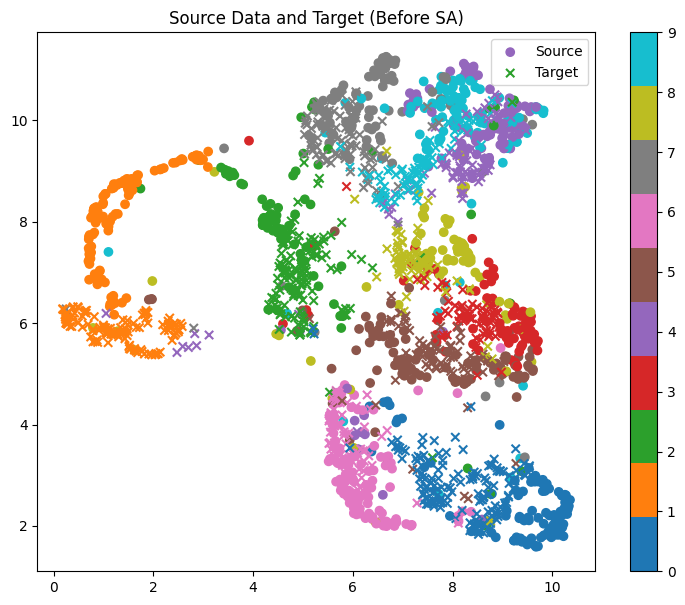

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


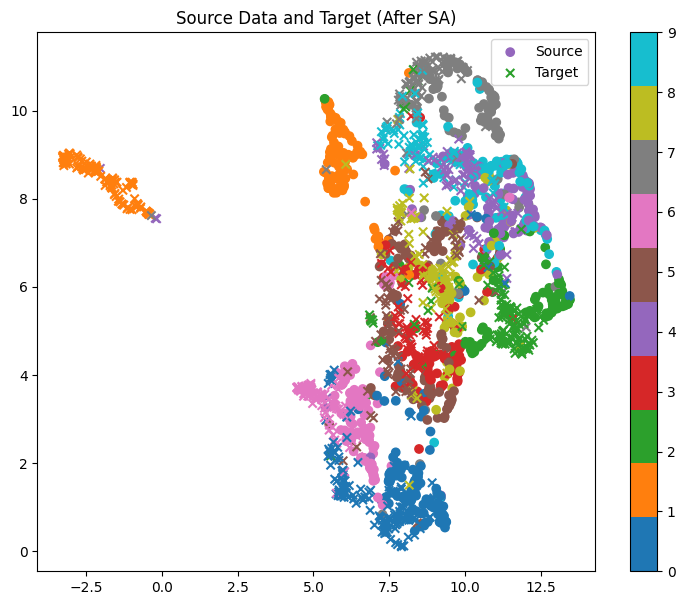

In [94]:
XTrainSp, _, XTrainTp, _ = SA(XtrainS, XtestS, XtrainT, XtestT, d=10)

# Visualize UMAP before SA
visualize_umap(XtrainS, XtrainT, ytrainS, ytrainT, title = "Source and Target Data (Before SA)")
# Visualize UMAP after SA
visualize_umap(XTrainSp, XTrainTp, ytrainS, ytrainT, title = "Source Data and Target Data (After SA)")

From the plots above, it can be observed that after applying the SA adaptaion, the distributions moved closer to each other, and became relatively more similar.

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

### 2. Source: MNIST, Target: SVHN

In [96]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
# XtrainT = USPS_Xtrain_res
# ytrainT = USPS_ytrain_res
# XtestT = USPS_Xtest
# ytestT = USPS_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

#### Without DA, on original dataset

In [97]:
start_time = time.time()
LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
LR_model.fit(XtrainS, ytrainS)
y_preds = LR_model.predict(XtestT)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f}s")
print("\nClassification Report:")
print(classification_report(ytestT, y_preds))
print("Accuracy:", accuracy_score(ytestT, y_preds))

Time taken: 5.14s

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.04      0.05      1744
           1       1.00      0.00      0.00      5099
           2       0.18      0.42      0.25      4149
           3       0.17      0.30      0.22      2882
           4       0.00      0.00      0.00      2523
           5       0.07      0.24      0.11      2384
           6       0.13      0.00      0.00      1977
           7       0.28      0.01      0.01      2019
           8       0.07      0.06      0.07      1660
           9       0.19      0.01      0.02      1595

    accuracy                           0.13     26032
   macro avg       0.21      0.11      0.07     26032
weighted avg       0.30      0.13      0.08     26032

Accuracy: 0.13087738168408114


#### Using PCA

In [98]:
# Experimenting with different values of d
d_values = [10, 30, 70, 100, 200, 300]

accuracy_scores = {}
time_taken = {}

for d in tqdm(d_values):
    XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = dim_red_pca(XtrainS, XtestS, XtrainT, XtestT, d = d)

    start_time = time.time()
    LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
    LR_model.fit(XtrainS_pca, ytrainS)
    y_preds = LR_model.predict(XtestT_pca)
    end_time = time.time()

    accuracy = accuracy_score(ytestT, y_preds)
    accuracy_scores[d] = accuracy
    time_taken[d] = end_time - start_time

print("Accuracy Scores for Different Values of d:")
for d, accuracy in accuracy_scores.items():
    print(f"d={d}: Accuracy={accuracy}, time taken = {time_taken[d]:.2f} s")

  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy Scores for Different Values of d:
d=10: Accuracy=0.09576674861708666, time taken = 0.32 s
d=30: Accuracy=0.11278426551936079, time taken = 0.24 s
d=50: Accuracy=0.13087738168408114, time taken = 0.80 s
d=70: Accuracy=0.1450522433927474, time taken = 0.83 s
d=100: Accuracy=0.10583128457283343, time taken = 0.59 s
d=200: Accuracy=0.10859711124769514, time taken = 1.02 s
d=300: Accuracy=0.12196527350952674, time taken = 0.59 s


#### Using SA

In [99]:
d_values = [10, 30, 70, 100, 200, 300]
results = {}

for d in tqdm(d_values):
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)
    LR_accuracy, SVC_accuracy, MLP_accuracy = evaluate_model(XTrainSp, XTestSp, XTrainTp, XTestTp, ytrainS, ytestT)
    results[d] = {'LR_accuracy': LR_accuracy, 'SVC_accuracy': SVC_accuracy, 'MLP_accuracy': MLP_accuracy}

print("Accuracies with different values of d:")
for d, acc in results.items():
    print(f"d={d}: LR Accuracy={acc['LR_accuracy']:.3f}, SVC Accuracy={acc['SVC_accuracy']:.3f}, MLP Accuracy={acc['MLP_accuracy']:.3f}")

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracies with different values of d:
d=10: LR Accuracy=0.093, SVC Accuracy=0.182, MLP Accuracy=0.083
d=30: LR Accuracy=0.115, SVC Accuracy=0.106, MLP Accuracy=0.088
d=70: LR Accuracy=0.125, SVC Accuracy=0.119, MLP Accuracy=0.107
d=100: LR Accuracy=0.102, SVC Accuracy=0.129, MLP Accuracy=0.145
d=200: LR Accuracy=0.102, SVC Accuracy=0.167, MLP Accuracy=0.097
d=300: LR Accuracy=0.123, SVC Accuracy=0.169, MLP Accuracy=0.114


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


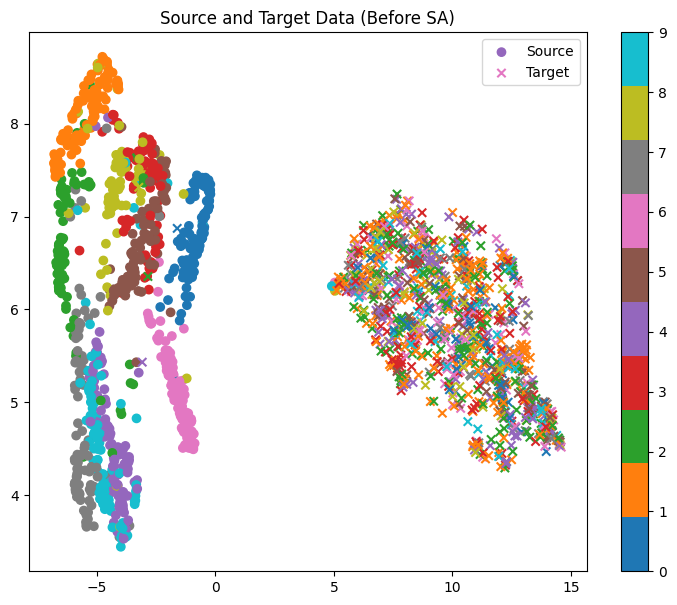

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


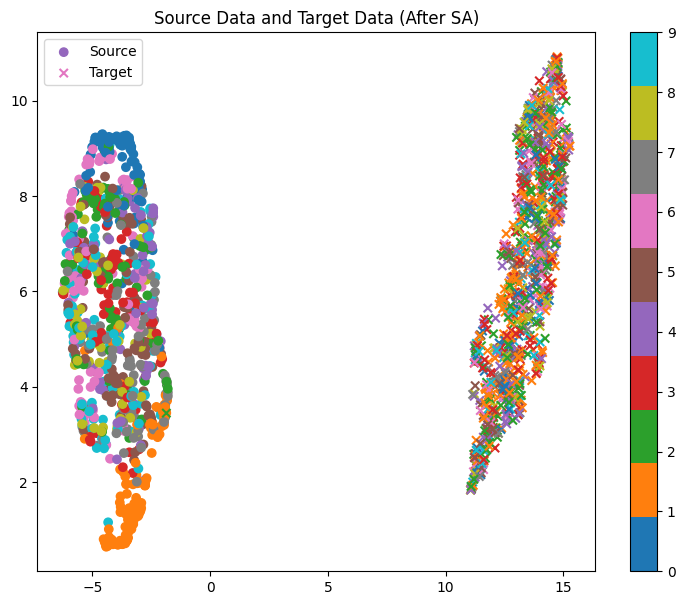

In [100]:
# Apply SA to the data
XTrainSp, _, XTrainTp, _ = SA(XtrainS, XtestS, XtrainT, XtestT, d=10)

# Visualize UMAP before SA
visualize_umap(XtrainS, XtrainT, ytrainS, ytrainT, title = "Source and Target Data (Before SA)")
# Visualize UMAP after SA
visualize_umap(XTrainSp, XTrainTp, ytrainS, ytrainT, title = "Source Data and Target Data (After SA)")

### 3. Source: USPS, Target: MNIST

In [101]:
# Source domain
XtrainS = USPS_Xtrain_res
ytrainS = USPS_ytrain_res
XtestS = USPS_Xtest
ytestS = USPS_ytest

# Target domain
XtrainT = MNIST_Xtrain_res
ytrainT = MNIST_ytrain_res
XtestT = MNIST_Xtest
ytestT = MNIST_ytest

#### Without DA, on original dataset

In [102]:
start_time = time.time()
LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
LR_model.fit(XtrainS, ytrainS)
y_preds = LR_model.predict(XtestT)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f}s")
print("\nClassification Report:")
print(classification_report(ytestT, y_preds))
print("Accuracy:", accuracy_score(ytestT, y_preds))

Time taken: 4.55s

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       980
           1       0.94      0.44      0.60      1135
           2       0.51      0.57      0.54      1032
           3       0.53      0.63      0.57      1010
           4       0.60      0.59      0.59       982
           5       0.40      0.59      0.48       892
           6       0.69      0.57      0.62       958
           7       0.66      0.52      0.58      1028
           8       0.51      0.54      0.52       974
           9       0.50      0.40      0.44      1009

    accuracy                           0.55     10000
   macro avg       0.58      0.55      0.55     10000
weighted avg       0.59      0.55      0.55     10000

Accuracy: 0.5493


#### Using PCA

In [103]:
# Experimenting with different values of d
d_values = [10, 30, 70, 100, 200, 300]

accuracy_scores = {}
time_taken = {}

for d in tqdm(d_values):
    XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = dim_red_pca(XtrainS, XtestS, XtrainT, XtestT, d = d)

    start_time = time.time()
    LR_model = LogisticRegression(random_state = 7, max_iter = 1000)
    LR_model.fit(XtrainS_pca, ytrainS)
    y_preds = LR_model.predict(XtestT_pca)
    end_time = time.time()

    accuracy = accuracy_score(ytestT, y_preds)
    accuracy_scores[d] = accuracy
    time_taken[d] = end_time - start_time

print("Accuracy Scores for Different Values of d:")
for d, accuracy in accuracy_scores.items():
    print(f"d={d}: Accuracy={accuracy}, time taken = {time_taken[d]:.2f} s")

  0%|          | 0/6 [00:00<?, ?it/s]

Accuracy Scores for Different Values of d:
d=10: Accuracy=0.5536, time taken = 0.12 s
d=30: Accuracy=0.5311, time taken = 0.19 s
d=70: Accuracy=0.5489, time taken = 0.21 s
d=100: Accuracy=0.5481, time taken = 0.13 s
d=200: Accuracy=0.5494, time taken = 0.39 s
d=300: Accuracy=0.5493, time taken = 0.36 s


#### Using SA

In [104]:
d_values = [10, 30, 70, 100, 200, 300]
results = {}

for d in tqdm(d_values):
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)
    LR_accuracy, SVC_accuracy, MLP_accuracy = evaluate_model(XTrainSp, XTestSp, XTrainTp, XTestTp, ytrainS, ytestT)
    results[d] = {'LR_accuracy': LR_accuracy, 'SVC_accuracy': SVC_accuracy, 'MLP_accuracy': MLP_accuracy}

print("Accuracies with different values of d:")
for d, acc in results.items():
    print(f"d={d}: LR Accuracy={acc['LR_accuracy']:.3f}, SVC Accuracy={acc['SVC_accuracy']:.3f}, MLP Accuracy={acc['MLP_accuracy']:.3f}")

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracies with different values of d:
d=10: LR Accuracy=0.402, SVC Accuracy=0.528, MLP Accuracy=0.331
d=30: LR Accuracy=0.536, SVC Accuracy=0.581, MLP Accuracy=0.483
d=70: LR Accuracy=0.548, SVC Accuracy=0.528, MLP Accuracy=0.449
d=100: LR Accuracy=0.550, SVC Accuracy=0.506, MLP Accuracy=0.465
d=200: LR Accuracy=0.549, SVC Accuracy=0.477, MLP Accuracy=0.357
d=300: LR Accuracy=0.550, SVC Accuracy=0.467, MLP Accuracy=0.385


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


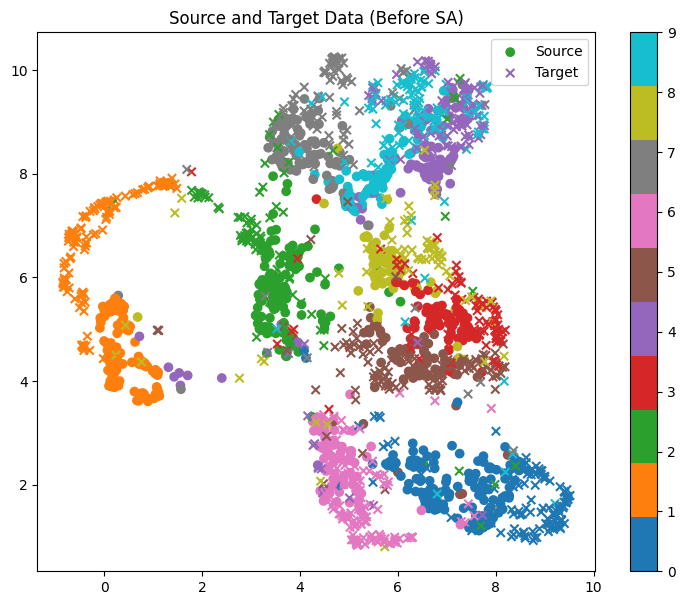

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


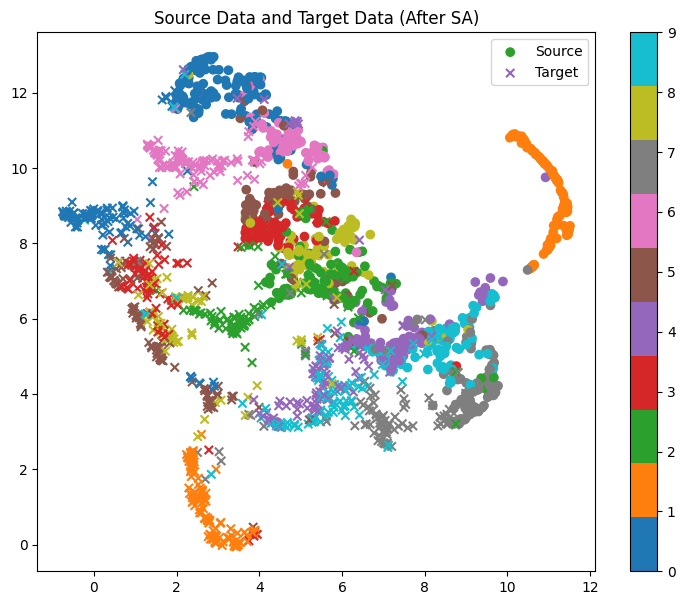

In [105]:
# Apply SA to the data
XTrainSp, _, XTrainTp, _ = SA(XtrainS, XtestS, XtrainT, XtestT, d=10)

# Visualize UMAP before SA
visualize_umap(XtrainS, XtrainT, ytrainS, ytrainT, title = "Source and Target Data (Before SA)")
# Visualize UMAP after SA
visualize_umap(XTrainSp, XTrainTp, ytrainS, ytrainT, title = "Source Data and Target Data (After SA)")

Applying the SA adaptation technique seemed to improve the performace drastically when the source dataset was MNIST and target was USPS, compared to training without domain adaptation or just dimensionality reduction using PCA. In the vice versa setting, there was a slight improvement in performance. However, when the source dataset was MNIST and the target was SVHN, it did not help at all. This is probably because SVHN is extremely different from MNIST, and even SA could not help overcome it.

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

Decreasing the number of samples for the labeled training set in domain adaptation, such as in methods like Subspace Alignment, can lead to diminished performance and increased risk of overfitting. With fewer labeled examples, the model may struggle to accurately capture the underlying structure of the source domain, potentially resulting in biased transformations and reduced generalization to the target domain. Moreover, the model becomes more sensitive to data variability, limiting its robustness and coverage of the data space. Having an adequate number of labeled samples is crucial for effective domain adaptation, ensuring better model performance to diverse target domains.

**Optional**: You can test other methods using the `adapt`library.

In [ ]:
!pip install adapt

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

In [ ]:
from adapt.feature_based import MDD
model = MDD(lambda_=0.1, gamma=4., Xt=XtrainT, metrics=["acc"], random_state=0)
model.fit(XtrainS, ytrainS, epochs=100, verbose=0)
model.score(XtrainS, ytrainS)


In [ ]:
from adapt.feature_based import DANN

model = DANN(lambda_=0.1, Xt=XtrainT, metrics=["acc"], random_state=0)
model.fit(XtrainS, ytrainS, epochs=100, verbose=0)
model.score(XtrainT, ytrainT)


**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...